In [ ]:
!pip install torch==2.9.0 torchcodec==0.9.1 torchaudio==2.9.0 torchao==0.14.0 executorch==1.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 148.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.3/538.3 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70

In [2]:
import os
import math
import random
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import Resample
from pathlib import Path

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_RATE = 16000
N_MELS = 40
N_FFT = 512
HOP_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 5e-4
NUM_CLASSES = 37  # Set below after dataset load
MODEL_SAVE = "tiny_kws2.pt"
SEED = 1234
torch.manual_seed(SEED)
random.seed(SEED)
print(DEVICE)

cuda


In [4]:
DO_TRAIN = True

In [5]:
import os

ROOT = "./speech_commands_data"
# Ensure the ROOT directory exists before attempting to download
os.makedirs(ROOT, exist_ok=True)
train_set = SPEECHCOMMANDS(ROOT, download=True, subset="training")
val_set = SPEECHCOMMANDS(ROOT, download=True, subset="validation")
test_set = SPEECHCOMMANDS(ROOT, download=True, subset="testing")

100%|██████████| 2.26G/2.26G [00:25<00:00, 96.4MB/s]


In [6]:
# Build label list for v0.02, including 'unknown' and 'silence'
# 'all_labels' will contain the 35 keywords from the dataset directories
all_labels = sorted(list({Path(p).parent.name for p in train_set._walker}))

# COMMON_COMMANDS should represent the full set of labels for v0.02
# Start with all_labels, then add 'unknown' and 'silence' if not already present
COMMON_COMMANDS = all_labels.copy()
if "unknown" not in COMMON_COMMANDS:
    COMMON_COMMANDS.append("unknown")
if "silence" not in COMMON_COMMANDS:
    COMMON_COMMANDS.append("silence")

labels = COMMON_COMMANDS
label_to_idx = {l:i for i,l in enumerate(labels)}
NUM_CLASSES = len(labels)
print(NUM_CLASSES)

37


In [7]:
from torch.utils.data import random_split

# Size of training set
train_size = len(train_set)
calib_size = int(0.1 * train_size)
train_size = train_size - calib_size

# Split training set into calib and train
train_subset, calib_subset = random_split(
    train_set,
    [train_size, calib_size],
    generator=torch.Generator().manual_seed(42)
)

In [8]:
class AudioProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, device=DEVICE):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.device = device
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            win_length=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            normalized=True
        ).to(self.device)

    def __call__(self, waveform):
        # Ensure waveform is on the correct device and has the right shape (channels, samples)
        if len(waveform.shape) == 1: # Mono audio
            waveform = waveform.unsqueeze(0)
        waveform = waveform.to(self.device)

        # Convert to Mel Spectrogram
        mel_spec = self.mel_spectrogram(waveform)

        # Convert to log scale (Decibels)
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # Remove the channel dimension if it's 1 (e.g., (1, n_mels, frames) -> (n_mels, frames))
        if mel_spec.shape[0] == 1:
            mel_spec = mel_spec.squeeze(0)
        return mel_spec

audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, device=DEVICE)


In [9]:
import os
import torch
from tqdm import tqdm

def preprocess_and_cache(
    dataset,
    split_name,
    audio_processor,
    label_to_idx,
    sample_rate,
    cache_root="mel_cache",
):
    split_dir = os.path.join(cache_root, split_name)
    os.makedirs(split_dir, exist_ok=True)

    target_length = sample_rate  # 1 second

    for idx in tqdm(range(len(dataset)), desc=f"Caching {split_name}"):
        cache_path = os.path.join(split_dir, f"{idx:06d}.pt")
        if os.path.exists(cache_path):
            continue  # skip if already cached

        waveform, _, label, *_ = dataset[idx]

        # Pad / trim
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        elif waveform.shape[1] < target_length:
            padding = torch.zeros(1, target_length - waveform.shape[1])
            waveform = torch.cat([waveform, padding], dim=1)

        # Feature extraction
        mel = audio_processor(waveform).cpu()

        torch.save(
            {
                "mel": mel,
                "label": label_to_idx[label],
            },
            cache_path,
        )

In [10]:
preprocess_and_cache(
    train_subset,
    split_name="train",
    audio_processor=audio_processor,
    label_to_idx=label_to_idx,
    sample_rate=SAMPLE_RATE,
)

preprocess_and_cache(
    val_set,
    split_name="val",
    audio_processor=audio_processor,
    label_to_idx=label_to_idx,
    sample_rate=SAMPLE_RATE,
)


Caching val: 100%|██████████| 9981/9981 [00:46<00:00, 216.72it/s]


In [11]:
preprocess_and_cache(
    test_set,
    split_name="test",
    audio_processor=audio_processor,
    label_to_idx=label_to_idx,
    sample_rate=SAMPLE_RATE,
)

preprocess_and_cache(
    calib_subset,
    split_name="calib",
    audio_processor=audio_processor,
    label_to_idx=label_to_idx,
    sample_rate=SAMPLE_RATE,
)

Caching calib: 100%|██████████| 8484/8484 [00:39<00:00, 213.50it/s]


In [12]:
class CachedMelDataset(torch.utils.data.Dataset):
    def __init__(self, cache_dir):
        self.cache_dir = cache_dir
        self.files = sorted(os.listdir(cache_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.cache_dir, self.files[idx]))
        return data["mel"], data["label"]

def collate_fn(batch):
    mels, labels = zip(*batch)
    return torch.stack(mels), torch.tensor(labels, dtype=torch.long)

In [13]:
train_loader = DataLoader(
    CachedMelDataset("mel_cache/train"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
)

val_loader = DataLoader(
    CachedMelDataset("mel_cache/val"),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=True,
)


In [14]:
test_loader = DataLoader(
    CachedMelDataset("mel_cache/test"),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=True,
)

calib_loader = DataLoader(
    CachedMelDataset("mel_cache/calib"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=True,
)

Batch shape (spectrograms): torch.Size([64, 40, 63])
Batch shape (labels): torch.Size([64])


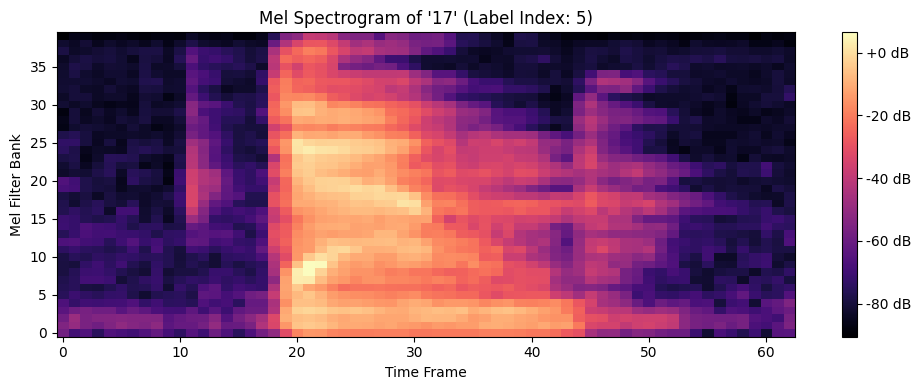

In [15]:
import matplotlib.pyplot as plt

# Get one batch from the training loader
samples, labels = next(iter(train_loader))

print(f"Batch shape (spectrograms): {samples.shape}")
print(f"Batch shape (labels): {labels.shape}")

# Take the first sample from the batch
spectrogram = samples[0].cpu().numpy()
label_idx = labels[0].item()
label_name = labels[label_idx]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, origin='lower', aspect='auto', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram of '{labels[label_idx]}' (Label Index: {label_idx})")
plt.xlabel("Time Frame")
plt.ylabel("Mel Filter Bank")
plt.tight_layout()
plt.show()

In [16]:
class ConvBNReLU(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class TinyKWS(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = ConvBNReLU(1, 12)
        self.block2 = ConvBNReLU(12, 24)
        self.block3 = ConvBNReLU(24, 32)
        self.block4 = ConvBNReLU(32, 32)
        self.block5 = ConvBNReLU(32, 32)

        self.pool = nn.AvgPool2d(2)

        self.fc = nn.Linear(32, NUM_CLASSES)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B,1,40,63)

        x = self.block1(x)
        x = self.pool(x)

        x = self.block2(x)
        x = self.pool(x)

        x = self.block3(x)
        x = self.pool(x)

        x = self.block4(x)
        x = self.pool(x)

        x = self.block5(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = TinyKWS().to(DEVICE)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for batch_idx, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        total_correct += (pred == y).sum().item()
        total += x.size(0)

        if (batch_idx + 1) % 100 == 0:
            current_loss = total_loss / total
            current_acc = total_correct / total
            print(f"  Batch {batch_idx + 1}/{len(loader)} | Loss: {current_loss:.4f} Acc: {current_acc:.3f}")

    return total_loss / total, total_correct / total

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            total_correct += (pred == y).sum().item()
            total += x.size(0)
    return total_loss / total, total_correct / total

In [ ]:
from functools import partial
if DO_TRAIN:
    best_val_acc = 0.0
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train loss {train_loss:.4f} acc {train_acc:.3f} | Val loss {val_loss:.4f} acc {val_acc:.3f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_SAVE)

  Batch 100/1194 | Loss: 3.4374 Acc: 0.092
  Batch 200/1194 | Loss: 3.1868 Acc: 0.190
  Batch 300/1194 | Loss: 2.9368 Acc: 0.280
  Batch 400/1194 | Loss: 2.7167 Acc: 0.346
  Batch 500/1194 | Loss: 2.5165 Acc: 0.400
  Batch 600/1194 | Loss: 2.3397 Acc: 0.446
  Batch 700/1194 | Loss: 2.1836 Acc: 0.486
  Batch 800/1194 | Loss: 2.0428 Acc: 0.522
  Batch 900/1194 | Loss: 1.9228 Acc: 0.551
  Batch 1000/1194 | Loss: 1.8164 Acc: 0.576
  Batch 1100/1194 | Loss: 1.7238 Acc: 0.598
Epoch 1/15 | Train loss 1.6470 acc 0.615 | Val loss 0.7061 acc 0.825
  Batch 100/1194 | Loss: 0.6935 Acc: 0.833
  Batch 200/1194 | Loss: 0.6549 Acc: 0.842
  Batch 300/1194 | Loss: 0.6412 Acc: 0.843
  Batch 400/1194 | Loss: 0.6257 Acc: 0.844
  Batch 500/1194 | Loss: 0.6118 Acc: 0.847
  Batch 600/1194 | Loss: 0.5981 Acc: 0.850
  Batch 700/1194 | Loss: 0.5880 Acc: 0.852
  Batch 800/1194 | Loss: 0.5772 Acc: 0.854
  Batch 900/1194 | Loss: 0.5702 Acc: 0.855
  Batch 1000/1194 | Loss: 0.5619 Acc: 0.857
  Batch 1100/1194 | Loss:

In [19]:
model = TinyKWS().to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE, map_location=DEVICE))
test_loss, test_acc = eval_model(model, test_loader, criterion, DEVICE)
print("Test acc:", test_acc)

Test acc: 0.9227623807360291


In [21]:
from torch.nn.utils import fuse_conv_bn_eval

def fold_bn(module):
    for name, child in module.named_children():
        if hasattr(child, "conv") and hasattr(child, "bn"):
            # Before fusing, ensure the conv layer doesn't have bias if it was explicitly False
            child.conv = fuse_conv_bn_eval(child.conv, child.bn)
            child.bn = nn.Identity()
        else:
            fold_bn(child)


model = TinyKWS().to(DEVICE) # Re-initialize
model.load_state_dict(torch.load(MODEL_SAVE, map_location=DEVICE))
model.eval()
fold_bn(model) # Fold BN

In [22]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 29265


In [23]:
import os

if DO_TRAIN:
    torch.save(model.state_dict(), MODEL_SAVE)

# Get the size of the saved file
model_size_bytes_file = os.path.getsize(MODEL_SAVE)
model_size_mb_file = model_size_bytes_file / (1024 * 1024)
print(f"Model size from saved file: {model_size_mb_file:.2f} MB")

Model size from saved file: 0.12 MB


# PTQ

In [25]:
from torchao.quantization.pt2e.quantize_pt2e import (
  prepare_qat_pt2e,
  prepare_pt2e,
  convert_pt2e,
)
from executorch.backends.xnnpack.quantizer.xnnpack_quantizer import (
  get_symmetric_quantization_config,
  XNNPACKQuantizer,
)
from torchao.quantization.pt2e import move_exported_model_to_eval
from torchao.quantization.pt2e import allow_exported_model_train_eval
from torchao.quantization.pt2e import move_exported_model_to_train

In [26]:
def evaluate(model, dataloader, device):
    # For nn.Module, move to device and set to eval mode.
    # For GraphModule (exported models), assume it's already on the correct device and in eval mode.
    # The user should ensure GraphModule is prepared (e.g., model.to(device), model.eval())
    # before calling this function.
    if not isinstance(model, torch.fx.GraphModule):
        model.to(device)
        model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100. * correct / total

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print("Size (MB):", os.path.getsize("temp.p")/1e6)
    os.remove("temp.p")

In [27]:
torch._dynamo.reset()
model.eval()
example_inputs = (torch.rand(BATCH_SIZE, N_MELS, 63).to(DEVICE),)
dynamic_shapes = (
    {0: torch.export.Dim("batch", min=1, max=BATCH_SIZE)},  # Batch dim dynamic
)

exported_model = torch.export.export(model, example_inputs, dynamic_shapes=dynamic_shapes).module()

quantizer = XNNPACKQuantizer()
quantizer.set_global(get_symmetric_quantization_config())

prepared_model = prepare_qat_pt2e(exported_model, quantizer)

In [28]:
def calibrate(model, data_loader, device):
    with torch.no_grad():
        for image, target in data_loader:
            image = image.to(device)
            model(image)

calibrate(prepared_model, calib_loader, DEVICE)  # Run calibration on calib data
converted_model = convert_pt2e(prepared_model)

In [29]:
try:
    # Check the _guards_fn
    prepared_model._guards_fn(torch.randn(1, N_MELS, 63).to(DEVICE))
except AssertionError as e:
    print("Guard assertion message:", e)

In [30]:
print_size_of_model(model)
print_size_of_model(converted_model)

Size (MB): 0.122121
Size (MB): 0.152485


In [31]:
fp32_acc = evaluate(model, test_loader, torch.device('cuda'))
int8_acc = evaluate(move_exported_model_to_eval(converted_model).to('cpu'), test_loader, torch.device('cpu'))
print(f'FP32 accuracy: {fp32_acc:.2f}%')
print(f'INT8 accuracy (FX PTQ): {int8_acc:.2f}%')

FP32 accuracy: 92.28%
INT8 accuracy (FX PTQ): 91.42%


In [32]:
import time

def benchmark_model(model, dataloader, device, runs=50):
    if not isinstance(model, torch.fx.GraphModule):
        model.to(device)
        model.eval()

    # Warmup
    with torch.no_grad():
      for i, (data, _) in enumerate(dataloader):
            if i >= 10:
                break
            data = data.to(device)
            _ = model(data)

    # Benchmark
    total = 0.0
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i >= runs:
                break
            data = data.to(device)
            t0 = time.time()
            _ = model(data)
            t1 = time.time()
            total += (t1 - t0)
    return (total / runs) * 1000.0  # ms per batch

In [33]:
fp32_time = benchmark_model(model, test_loader, torch.device('cpu'), runs=300)
int8_time = benchmark_model(move_exported_model_to_eval(converted_model).to('cpu'), test_loader, torch.device('cpu'), runs=300)
print(f'FP32 avg time per batch: {fp32_time:.2f} ms')
print(f'INT8 avg time per batch: {int8_time:.2f} ms')

FP32 avg time per batch: 22.68 ms
INT8 avg time per batch: 36.71 ms


In [ ]:
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir import to_edge_transform_and_lower
from torch.export import export
from executorch.exir import EdgeCompileConfig, to_edge_transform_and_lower

example_inputs = (torch.rand(1, N_MELS, 63),)

edge = to_edge_transform_and_lower(
    export(converted_model.to('cpu'), example_inputs), # Export to CPU
    compile_config=EdgeCompileConfig(_check_ir_validity=False),
    partitioner=[XnnpackPartitioner()]
)

exec_prog = edge.to_executorch()

with open("tiny_kws2.pte", "wb") as file:
    exec_prog.write_to_file(file)

In [1]:
from pathlib import Path

pte_path = Path("tiny_kws2.pte")
output_path = Path("model_pte.h")

data = pte_path.read_bytes()
hex_bytes = [f"0x{b:02x}" for b in data]
lines = [", ".join(hex_bytes[i:i+12]) for i in range(0, len(hex_bytes), 12)]

output_path.write_text(f"""#ifndef MODEL_PTE_H
#define MODEL_PTE_H

#include <stdint.h>

const uint8_t model_pte[] __attribute__((aligned(8))) = {{
{",".join("    " + l for l in lines)}
}};

const unsigned int model_pte_len = {len(data)};

#endif
""")

287499